In [1]:
!python -V

Python 3.11.9


In [16]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from math import floor

In [17]:
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Set the seed for reproducibility
random.seed(42)

# Define paths
dataset_dir = r'C:\Users\USER\Documents\Kuliah\CompVis\Dataset'  # Path to your dataset folder
output_dir = r'C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data'    # Path where train, valid, and test folders will be created

# Classes inside the dataset folder
class_names = ['Front', 'Left Tilt', 'Right Tilt', 'Duck']

# Define split ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Create output directories for train, valid, and test
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the dataset
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle the data

    # Calculate split sizes
    train_size = floor(len(images) * train_ratio)
    valid_size = floor(len(images) * valid_ratio)

    # Create class directories for each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split images into train, valid, and test
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Copy the files to the respective directories
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in valid_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(valid_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copyfile(src, dst)

    print(f"Class '{class_name}': {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test")

print("Dataset successfully split!")


Class 'Front': 707 train, 202 valid, 102 test
Class 'Left Tilt': 606 train, 173 valid, 88 test
Class 'Right Tilt': 725 train, 207 valid, 105 test
Class 'Duck': 568 train, 162 valid, 82 test
Dataset successfully split!


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # This step requires NumPy to be available
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
from PIL import Image

def pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None
    
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'], loader=pil_loader)
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'], loader=pil_loader)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'], loader=pil_loader)

In [9]:
# Setup the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained Vision Transformer model
pretrained_vit = models.vit_b_16(pretrained=True)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))  # Change to 4 classes
pretrained_vit = pretrained_vit.to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=1e-4)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
patience_counter = 0

In [9]:
# Training function with epoch indication
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device, early_stopping_patience):
    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []

    best_val_loss = float('inf')  # Initialize best_val_loss for early stopping
    patience_counter = 0  # Initialize patience counter for early stopping

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print the current epoch

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

            # Optionally, show progress for each batch within the epoch
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)} processed...")

        # Calculate train loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_predictions += torch.sum(preds == labels.data)
                total_val_predictions += labels.size(0)

        val_loss = running_val_loss / len(valid_loader.dataset)
        val_acc = correct_val_predictions.double() / total_val_predictions

        valid_loss_history.append(val_loss)
        valid_acc_history.append(val_acc.item())

        # Print epoch result
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history

# Train the model
train_loss, valid_loss, train_acc, valid_acc = train_model(pretrained_vit, train_loader, valid_loader, loss_fn, optimizer, epochs=50, device=device, early_stopping_patience=early_stopping_patience)

Epoch 1/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 1/50 - Train Loss: 0.2949, Train Acc: 0.8960, Val Loss: 0.1076, Val Acc: 0.9677
Epoch 2/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 2/50 - Train Loss: 0.0640, Train Acc: 0.9804, Val Loss: 0.0601, Val Acc: 0.9758
Epoch 3/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 3/50 - Train Loss: 0.0146, Train Acc: 0.9969, Val Loss: 0.0516, Val Acc: 0.9852
Epoch 4/50
Batch 0/82 processed...
Ba

In [13]:
# Load the best model for evaluation
pretrained_vit.load_state_dict(torch.load('best_model.pth'))
pretrained_vit.eval()

C:\Users\USER\AppData\Local\Temp\ipykernel_24936\2394646552.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_vit.load_state_dict(torch.load('best_model.pth'))


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
# Load the best model for evaluation
model = models.vit_b_16(pretrained=True)
model.heads = nn.Linear(in_features=768, out_features=len(class_names))  # Sesuaikan dengan jumlah kelas
model.load_state_dict(torch.load('best_model (2).pth'))  # Memuat model terbaik yang sudah disimpan
model = model.to(device)
model.eval()  # Mengatur model ke dalam mode evaluasi

C:\Users\USER\AppData\Local\Temp\ipykernel_32356\2796855304.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model (2).pth'))  # Me

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [47]:
# Load the best model for evaluation
model = models.vit_b_16(pretrained=True)
model.heads = nn.Linear(in_features=768, out_features=len(class_names))  # Sesuaikan dengan jumlah kelas
model.load_state_dict(torch.load('best_model.pth'))  # Memuat model terbaik yang sudah disimpan
model = model.to(device)
model.eval()  # Mengatur model ke dalam mode evaluasi

# Tambahkan fungsi untuk menampilkan jumlah parameter dengan format yang rapi
def model_summary_custom(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    # Format output seperti gambar
    print("Total params: {:,} ({:.2f} MB)".format(total_params, total_params * 4 / (1024 ** 2)))
    print("Trainable params: {:,} ({:.2f} MB)".format(trainable_params, trainable_params * 4 / (1024 ** 2)))
    print("Non-trainable params: {:,} ({:.2f} KB)".format(non_trainable_params, non_trainable_params * 4 / 1024))

# Tampilkan ringkasan parameter model
model_summary_custom(model)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total params: 85,801,732 (327.31 MB)
Trainable params: 85,801,732 (327.31 MB)
Non-trainable params: 0 (0.00 KB)


C:\Users\USER\AppData\Local\Temp\ipykernel_24936\3491863112.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Memuat

In [27]:
# Evaluate on the test set
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [54]:
from sklearn.metrics import average_precision_score

def calculate_map(y_true, y_pred, class_names):
    # Convert labels to one-hot encoding
    y_true_one_hot = np.eye(len(class_names))[y_true]
    
    # Calculate average precision for each class
    average_precisions = []
    for i in range(len(class_names)):
        average_precision = average_precision_score(y_true_one_hot[:, i], y_pred[:, i])
        average_precisions.append(average_precision)
    
    # Calculate mean average precision
    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

# Assuming y_pred contains the raw output scores from the model
with torch.no_grad():
    y_pred_scores = []
    y_true_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_pred_scores.extend(outputs.cpu().numpy())
        y_true_labels.extend(labels.cpu().numpy())

y_pred_scores = np.array(y_pred_scores)
y_true_labels = np.array(y_true_labels)

# Calculate mAP
map_score = calculate_map(y_true_labels, y_pred_scores, class_names)
print(f"Mean Average Precision (mAP): {map_score:.4f}")

Mean Average Precision (mAP): 0.9999


In [28]:
# Get predictions and labels for the test set
y_pred, y_true = evaluate_model(pretrained_vit, test_loader, device)

In [29]:
# Plot training and validation loss/accuracy
def plot_training_results(train_loss, valid_loss, train_acc, valid_acc):
    epochs_range = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, valid_loss, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, valid_acc, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

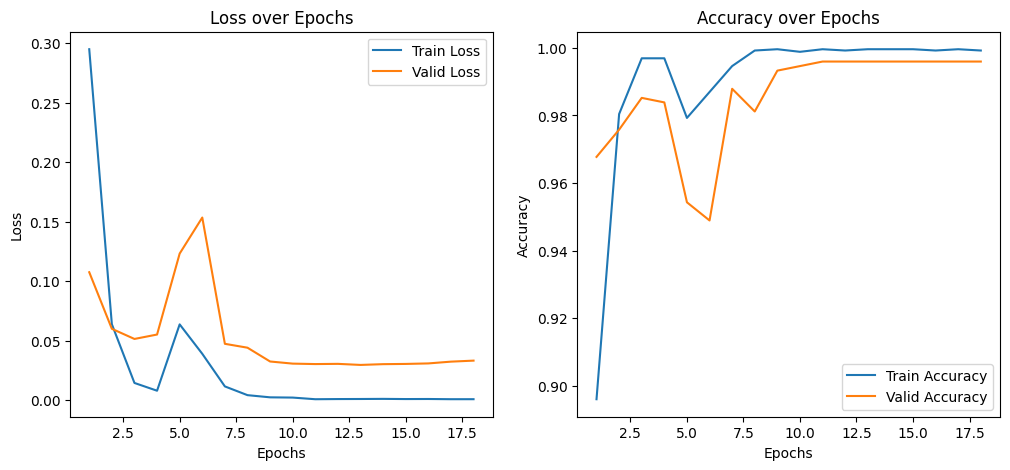

In [30]:
# Plot the training results
plot_training_results(train_loss, valid_loss, train_acc, valid_acc)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score (macro and per-class)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1:.4f}")

# For per-class precision, recall, and F1-score:
precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

for idx, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[idx]:.4f}")
    print(f"  Recall: {recall_per_class[idx]:.4f}")
    print(f"  F1-Score: {f1_per_class[idx]:.4f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.9973
Precision (macro): 0.9970
Recall (macro): 0.9975
F1-Score (macro): 0.9973
Class: Front
  Precision: 0.9880
  Recall: 1.0000
  F1-Score: 0.9939
Class: Right Tilt
  Precision: 1.0000
  Recall: 0.9902
  F1-Score: 0.9951
Class: Left Tilt
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Class: Duck
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000


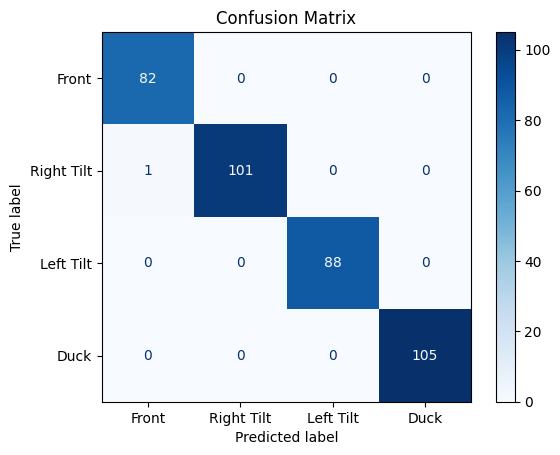

In [33]:
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

<timed exec>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Randomly selected image: C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data\test\Left Tilt\M.Alif_MiringKiri_7.jpg


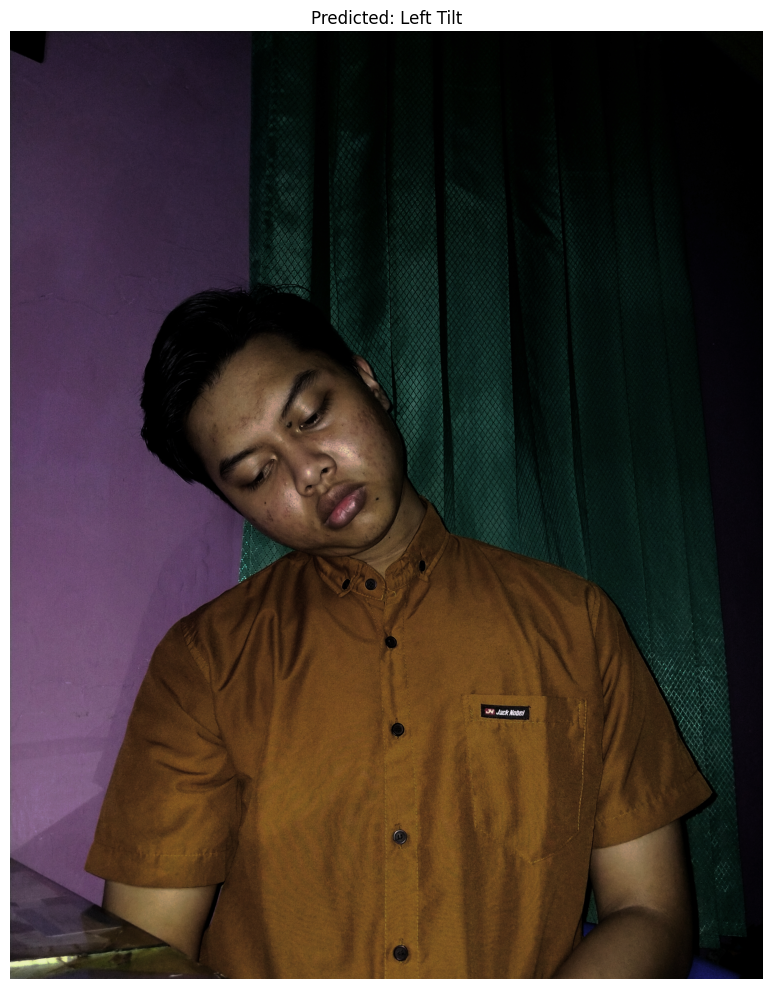

CPU times: total: 625 ms
Wall time: 1.49 s


In [53]:
%%time
# Initialize the model architecture (replace with your specific model architecture)
model = models.vit_b_16(weights=None)  # Initialize the model architecture without pretrained weights

# Modify the classifier head to match your number of classes (e.g., 4 classes)
model.heads = torch.nn.Linear(in_features=768, out_features=4)  # Adjust based on your model

# Load the state dictionary
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))  # Load the weights

# Set the model to evaluation mode
model.eval()

# Move the tensor to the same device as the model (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the test folder path
testFolderPath = r'C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data\test'

# Ensure the folder exists
assert os.path.exists(testFolderPath), f"Folder not found at {testFolderPath}"

# Recursively get a list of all image files in the test folder (including subdirectories)
imageFiles = []
for root, dirs, files in os.walk(testFolderPath):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            imageFiles.append(os.path.join(root, file))

# Ensure there are images in the folder
assert len(imageFiles) > 0, f"No image files found in the folder {testFolderPath}"

# Randomly pick an image
randomImagePath = random.choice(imageFiles)

# Debugging: Print the randomly selected image path
print(f"Randomly selected image: {randomImagePath}")

# Load and preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])

# Open the image using PIL and apply the preprocessing
image = Image.open(randomImagePath)
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Perform the prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

# Define your class names
class_names = ['Duck', 'Front', 'Left Tilt', 'Right Tilt']

# Get the predicted class
predicted_label = class_names[predicted_class.item()]

# Display the image with predicted label
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
ax.set_title(f"Predicted: {predicted_label}")
ax.axis('off')

plt.tight_layout()
plt.show()

In [48]:
from torchvision import datasets

# Assuming the train dataset was loaded using ImageFolder
train_dataset = datasets.ImageFolder(r'C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data\test')
print(train_dataset.class_to_idx)


{'Duck': 0, 'Front': 1, 'Left Tilt': 2, 'Right Tilt': 3}


In [21]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])

# Define your class names
class_names = ['Duck', 'Front', 'Left Tilt', 'Right Tilt']

# Access the camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to PIL image
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Preprocess the image
        input_tensor = preprocess(pil_image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)
        input_tensor = input_tensor.to(device)

        # Perform the prediction
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_class = torch.max(output, 1)

        # Get the predicted class
        predicted_label = class_names[predicted_class.item()]

        # Display the frame with predicted label
        cv2.putText(frame, f"Predicted: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Camera', frame)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close windows
    cap.release()
    cv2.destroyAllWindows()